# CSE144 Final Project
Group Members: Russell Elliott, Neil Grover

In [989]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models

In [990]:
#Training Data
X = torch.load('train_data.pth')
y = torch.load('train_labels.pth') 

#Make a model for training on the train data via a validation set. From there, we'll test our model via the test set
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [991]:
# Fix seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

In [1005]:
# Create custom dataset class
class SimpsonsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = int(self.y[idx])
        return image, label

# Create datasets
train_dataset = SimpsonsDataset(X_train, y_train)
test_dataset = SimpsonsDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [1006]:
class VGG16Head(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16Head, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12288, 1280),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):

        x = self.classifier(x)
        return x

model = models.vgg16(pretrained=True)
net = VGG16Head()
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [1004]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the network
num_epochs = 50
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, net)
    train_acc.append(train_accuracy)

    test_loss = 0.0
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = calculate_accuracy(test_loader, net)
    test_acc.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch 1/50, Train Loss: 6662.7503, Train Acc: 1.00%, Test Loss: 16731.5237, Test Acc: 1.00%
Epoch 2/50, Train Loss: 17678.1271, Train Acc: 3.12%, Test Loss: 28352.6221, Test Acc: 2.00%
Epoch 3/50, Train Loss: 21283.1929, Train Acc: 1.12%, Test Loss: 17733.6123, Test Acc: 1.00%
Epoch 4/50, Train Loss: 14130.8199, Train Acc: 3.88%, Test Loss: 10501.2338, Test Acc: 0.50%
Epoch 5/50, Train Loss: 11945.9101, Train Acc: 4.00%, Test Loss: 10842.9431, Test Acc: 1.00%
Epoch 6/50, Train Loss: 10407.5691, Train Acc: 6.88%, Test Loss: 7950.8307, Test Acc: 4.50%
Epoch 7/50, Train Loss: 6223.5785, Train Acc: 9.75%, Test Loss: 5823.3207, Test Acc: 2.00%
Epoch 8/50, Train Loss: 4206.1511, Train Acc: 16.88%, Test Loss: 3649.1097, Test Acc: 2.50%
Epoch 9/50, Train Loss: 2087.6272, Train Acc: 29.62%, Test Loss: 2088.9644, Test Acc: 1.50%
Epoch 10/50, Train Loss: 989.4705, Train Acc: 40.25%, Test Loss: 1625.0770, Test Acc: 8.00%
Epoch 11/50, Train Loss: 660.3600, Train Acc: 45.12%, Test Loss: 1259.0495, T

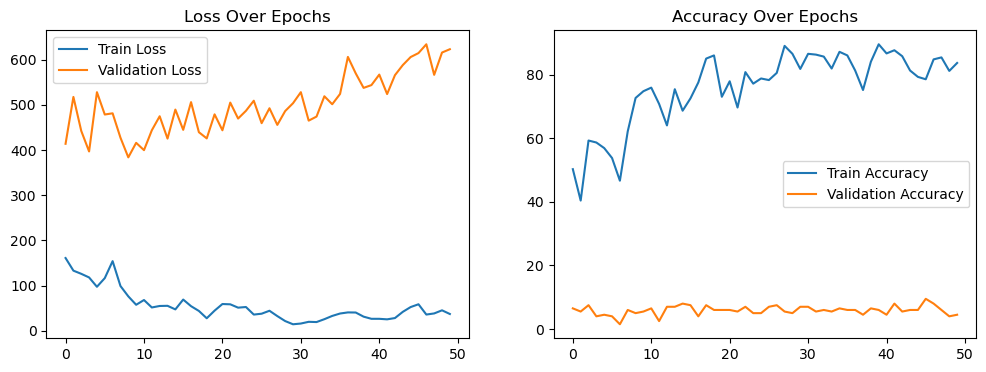

In [1002]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()